In [ ]:
import os, io, wave, csv, json, re, glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.fftpack import dct
import matplotlib.cm as cm
import matplotlib as mpl
import collections
import seaborn as sns
from keras import optimizers

from sklearn.externals import joblib

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dropout

In [ ]:
import numpy
import os
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

config = tf.ConfigProto(device_count = {'GPU': 0})
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True

In [ ]:
def generateBalancedData(X_more, y_more, size):
    """
    X_more = de input data
    y_more = de label data
    size = de maximum grootte die je wenst bijv. 300000 data totaal
    """
    
    pos_list = [i for i, x in enumerate(y_more) if x == 1][:int(size/2)]
    neg_list = [i for i, x in enumerate(y_more) if x == 0][:int(size/2)]

    balancedDataX = np.concatenate(([X_more[pos] for pos in pos_list], [X_more[neg] for neg in neg_list]), axis=0)
    
    balancedDataY = np.concatenate(([y_more[pos] for pos in pos_list], [y_more[neg] for neg in neg_list]), axis=0)
        
    return [balancedDataX, balancedDataY]

In [ ]:
csv_file_name = 'datasetboundary_distance_4ms_v1.csv'

In [223]:
# Map waar het csv bestand zit
data_corpus_path = '/datb/aphasia/languagedata/corpus/dataset/' + csv_file_name


# Inlezen CSV bestand
df_corpus_data = pd.read_csv(data_corpus_path, sep=',', skiprows=1,
                             names=['region', 'label', 'sample_rate', 'begin', 'end', 'audiopath'])


# Voor het weghalen van 'nan' rows in de column "region"
df_corpus = df_corpus_data.dropna(subset=['region'])

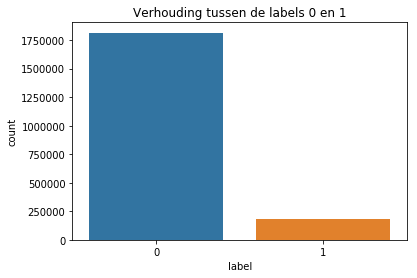

In [224]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='label', data=df_corpus)
plt.title("Verhouding tussen de labels 0 en 1")
plt.show()

In [225]:
# Get input data
X = []

for x in df_corpus.region:
    trans = [float(y) for y in x.split('|')]
    X.append(trans)

# Get labels
y = [int(x) for x in df_corpus.label]

print('Before generating more 1 labels data')
print('X:{}'.format(len(X)))
print('y:{}'.format(len(y)))

Before generating more 1 labels data
X:1996214
y:1996214


In [226]:
dataSize = 300000

In [227]:
X_more, y_more = generateBalancedData(X, y, dataSize)

print('After generating more 1 labels data')
print('X:{}'.format(len(X_more)))
print('y:{}'.format(len(y_more)))

After generating more 1 labels data
X:300000
y:300000


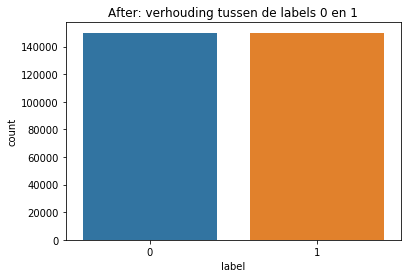

In [228]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='label', data=pd.DataFrame({'label':y_more}))
plt.title("After: verhouding tussen de labels 0 en 1")
plt.show()

In [229]:
test_size = 0.20
random_state = 42

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X_more, y_more, test_size=test_size, 
                                                    random_state=random_state, stratify=y_more)

In [231]:

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils import plot_model
from IPython.display import SVG



In [250]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)

In [318]:
# define baseline model
def  create_baseline():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(52,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    adam = optimizers.Adam(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])
    
    return model

In [311]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=1000, verbose=1)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
# results = cross_val_score(estimator, X_train, encoded_Y, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
history = estimator.fit(X_train, encoded_Y, validation_split=0.10, epochs=100, batch_size=100, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [321]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

In [322]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

NameError: name 'model' is not defined

In [306]:
# file name
filename = 'mlp_model_test_H7_la_small_scikit_n120_h3_l00001_i4000.sav'

# In map
folder = '/datb/aphasia/languagedata/corpus/result/'

In [307]:
# load the model from disk
loaded_model = joblib.load(open(folder+filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print('Test_score:{}'.format(test_score))

NameError: name 'test_score' is not defined

In [308]:
# save the model to disk
joblib.dump(mlp, folder+filename)

NameError: name 'mlp' is not defined